<a href="https://colab.research.google.com/github/vachaconcu/Mineriadatos/blob/master/Cambioedad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [0]:
tar = tarfile.open('/content/drive/My Drive/Edad/DATOS_EDAD.tar.gz')
tar.extractall()

import pandas as pd
at = pd.read_csv('/content/drive/My Drive/Edad/DATOS.csv',sep=" ")
os.chdir('/content/DATOS_EDAD')

joven = []
for i in range(1,571):
  img = load_img(at.w2[i])
  img_array = img_to_array(img)
  img_array = img_array/255
  joven.append(img_array)

viejo = []
for i in range(1,571):
  img = load_img(at.w[i])
  img= img.resize((104,104))
  img_array = img_to_array(img)
  img_array = img_array/255
  viejo.append(img_array)


In [0]:
joven = np.array(joven) 
viejo = np.array(viejo)
print(joven.shape)
print(viejo.shape)

(570, 100, 100, 3)
(570, 104, 104, 3)


In [0]:
from sklearn.model_selection import train_test_split
joven,test=train_test_split(joven, test_size=0.2, random_state=42)
viejo,test2=train_test_split(viejo, test_size=0.2, random_state=42)

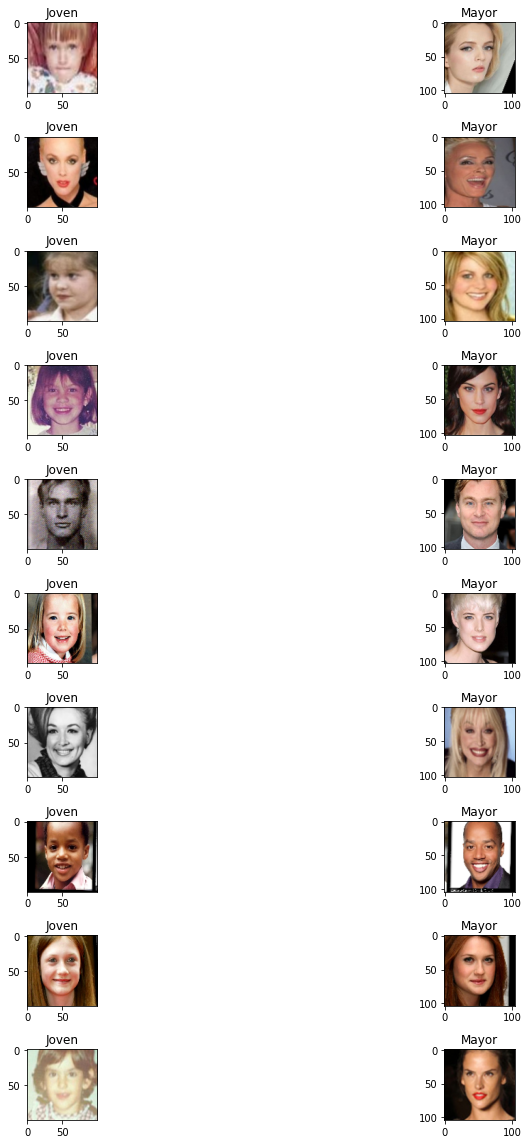

In [0]:
os.chdir('/content/drive/My Drive/Mineria/Retrato')
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

fig, axes = plt.subplots(10, 2, figsize=(16,16))
ax = axes.ravel()
r=0
for i in range(80,90):
  ax[r].imshow(joven[i])
  ax[r].set_title("Joven")
  ax[r+1].imshow(viejo[i])
  ax[r+1].set_title("Mayor")
  r=r+2

fig.tight_layout()
plt.show()

In [0]:
input_shape = joven[1].shape
batch_size = 32
kernel_size = 3
latent_dim = 300

(None, 50, 50, 32)
(None, 25, 25, 64)
(None, 13, 13, 128)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 300)               6489900   
Total params: 6,583,148
Trainable params: 6,583,148
Non-trainable p

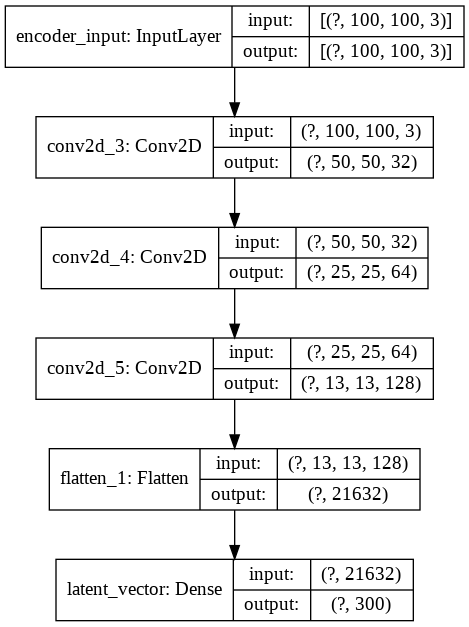

In [0]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64,128]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    shape = K.int_shape(x)
    print(shape)
    
shape = K.int_shape(x)    
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)



In [0]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 300)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 21632)             6511232   
_________________________________________________________________
reshape_1 (Reshape)          (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 26, 26, 128)       147584    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 52, 52, 64)        73792     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 104, 104, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 104, 104, 3)       867 

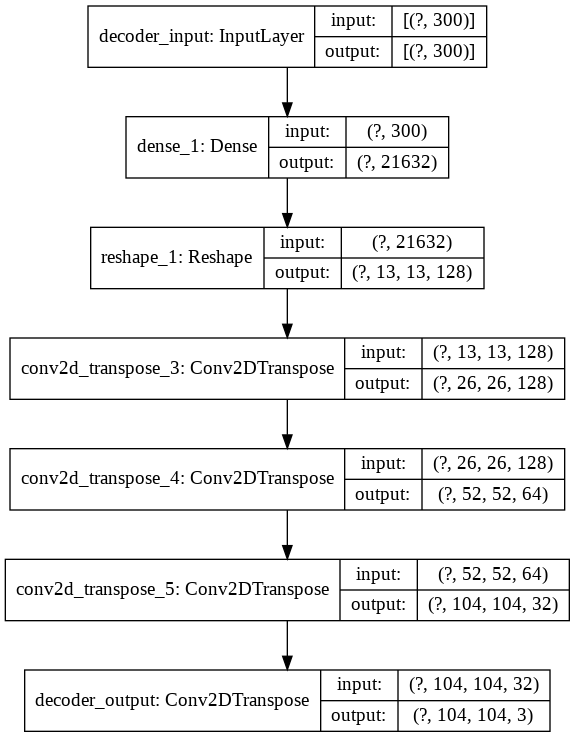

In [0]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100, 100, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 300)               6583148   
_________________________________________________________________
decoder (Model)              (None, 104, 104, 3)       6751939   
Total params: 13,335,087
Trainable params: 13,335,087
Non-trainable params: 0
_________________________________________________________________


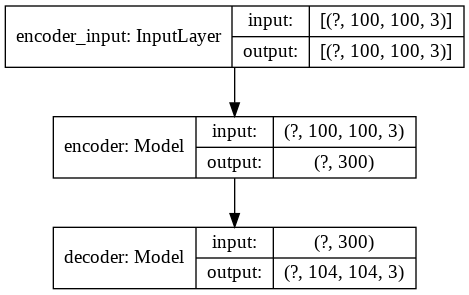

In [0]:
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

In [0]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [0]:
import tensorflow as tf
import keras
os.chdir('/content/drive/My Drive/Edad')
checkpoint_path = "training_1/cp_{epoch}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 save_weights_only=True,
                                                 save_best_only=True)

In [0]:
# train the autoencoder
history= autoencoder.fit(joven,viejo,validation_split=0.1,batch_size=32,callbacks=[cp_callback],epochs=100)

Epoch 1/100
13/13 [==============================] - 3s 220ms/step - loss: 0.0894 - val_loss: 0.0880
Epoch 2/100
13/13 [==============================] - 2s 161ms/step - loss: 0.0800 - val_loss: 0.0775
Epoch 3/100
13/13 [==============================] - 2s 119ms/step - loss: 0.0735 - val_loss: 0.0691
Epoch 4/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0715 - val_loss: 0.0730
Epoch 5/100
13/13 [==============================] - 1s 112ms/step - loss: 0.0707 - val_loss: 0.0678
Epoch 6/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0697 - val_loss: 0.0683
Epoch 7/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0679 - val_loss: 0.0700
Epoch 8/100
13/13 [==============================] - 1s 64ms/step - loss: 0.0684 - val_loss: 0.0694
Epoch 9/100
13/13 [==============================] - 1s 64ms/step - loss: 0.0660 - val_loss: 0.0726
Epoch 10/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0624 - val_loss: 0.

In [0]:
viejo.shape

(456, 104, 104, 3)

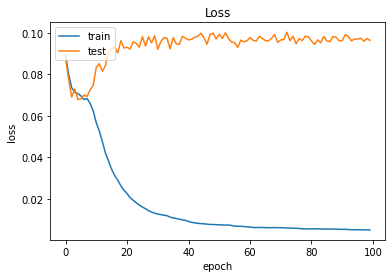

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
x_decoded = autoencoder.predict(test)

In [0]:
autoencoder.load_weights('/content/drive/My Drive/Edad/training_1/cp_5.ckpt')

In [0]:
autoencoder.evaluate(test,test2, verbose=2)

4/4 - 0s - loss: 0.0709


0.07088497281074524

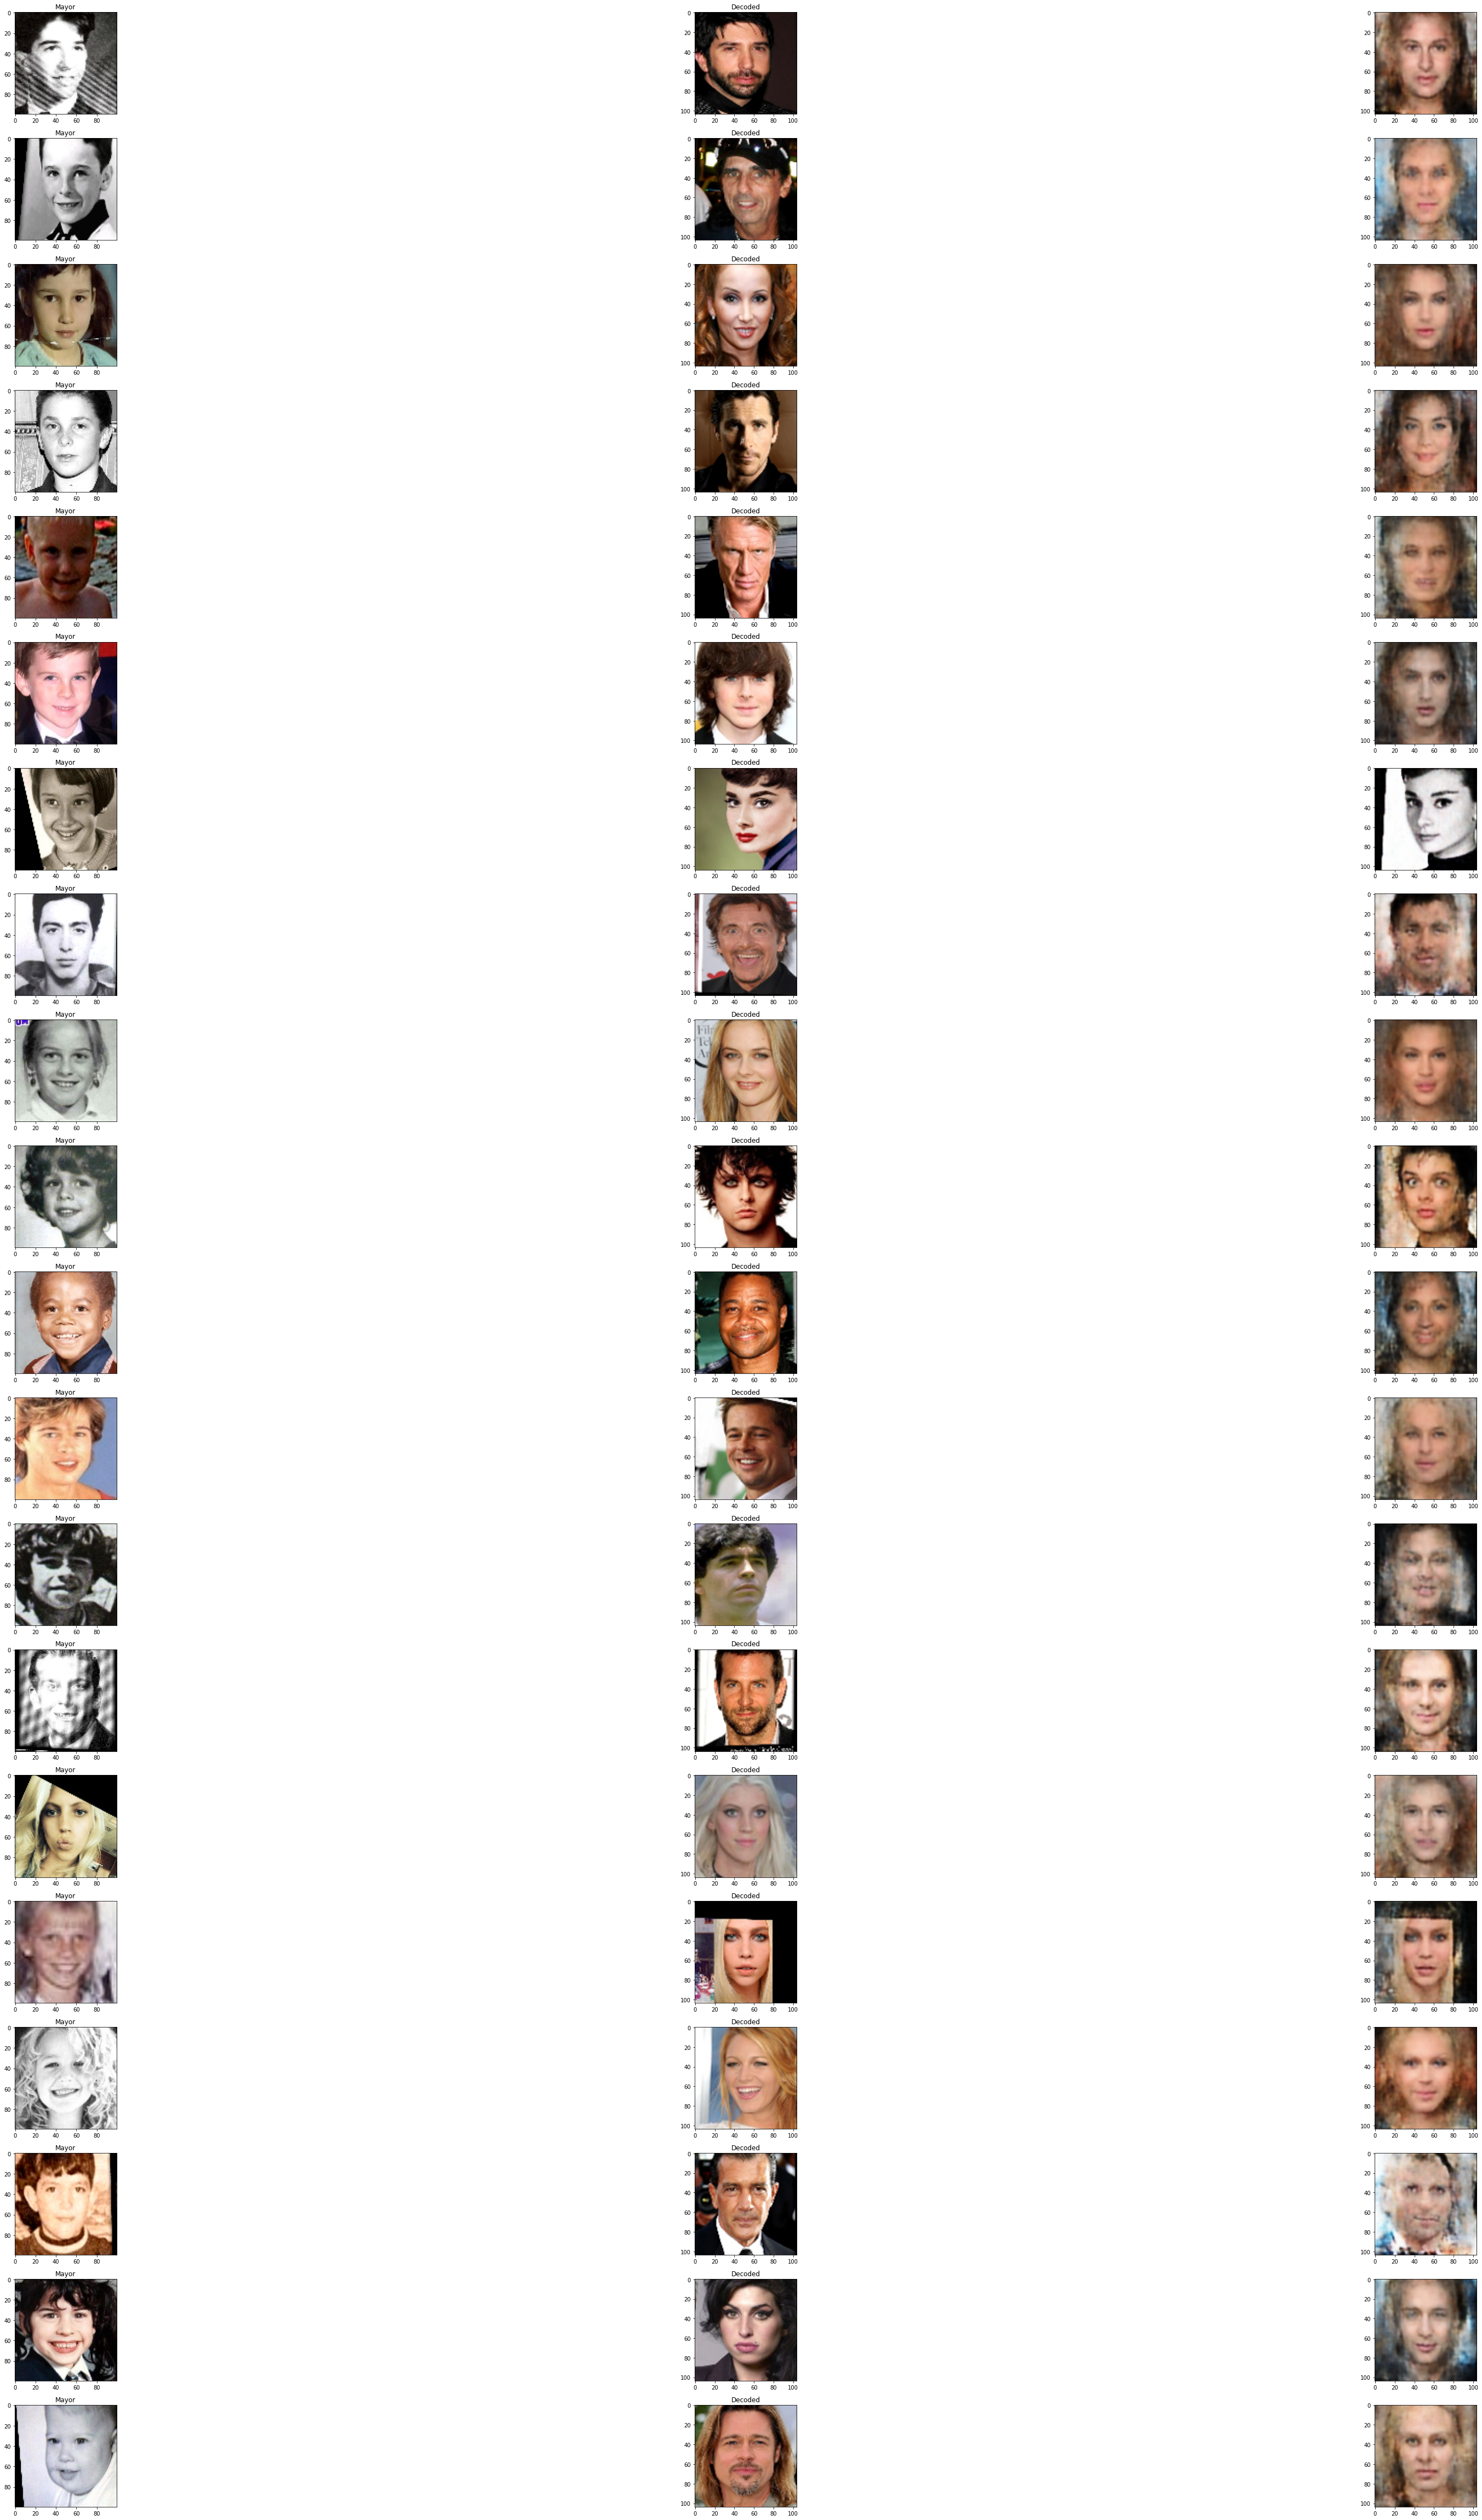

In [0]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

fig, axes = plt.subplots(20, 3, figsize=(64,64))
ax = axes.ravel()
r=0
for i in range(0,20):
  ax[r].set_title("Joven")
  ax[r].imshow(test[i])
  ax[r].set_title("Mayor")
  ax[r+1].imshow(test2[i])
  ax[r+1].set_title("Decoded")
  image = np.squeeze(x_decoded[i])
  ax[r+2].imshow(image)
  r=r+3

fig.tight_layout()
plt.show()